Описание подхода:
 1. Сначала я проанализировал данные по истории баланса для выделения "хороших" и "плохих" клиентов;
 2. После этого задача свелась к задаче классификации на 2 класса: я использовал градиентный бустинг на решающих деревьях в реализации библиотеки LightGBM.
 3. В конце я использовал SHAP для визуализации вкладов от разных атрибутов в модель.

Таргет:
 - В качестве "плохих" клиентов я взял пользователей, которые в течение первых 20 месяцев уходили в просрочку на >= 30 дней. Таких оказалось порядка 12% от всех клиентов;
 - Всех остальных клиентов принял за "хороших";
 - Период наблюдения я выбрал 20 месяцев: за это время проявляется около 95% всех "плохих" клиентов.
 
Вариант пилота модели:
 * Для принятия решения по модели, выдавать кредит, или нет, скорее всего, нужно оптимизировать "денежную" метрику, важную для банка: например, "доход с заявки". Иначе, даже имея модель с очень хорошими ML метриками, можно уйти в минус по деньгам.
 * Я бы использовал модель в общей оценке доходности с пула клиентов (например, с близким скором по модели), где помимо вероятности уйти в дефолт на каком-то горизонте стоит учитывать весь потенциальный профит (выплатит кредит + штрафы по просрочке) и потери (пример: резерв на случай дефолта).

Описание "хорошего" клиента (исходя из SHAP):
 1. Состоит в браке
 2. Источник дохода - работа/коммерческий партнёр/гос.служащий
 3. Образование: высшее или средне-специальное
 4. Есть дети
 5. Небольшая семья
 
Вероятностный характер скоров модели:
 * По графику калибровочной кривой мы видим, что скор модели почти всегда выше соответствующей вероятности (доле 1-го класса). Его можно использовать как верхнюю оценку вероятности, причём она тем точнее, чем выше значение скора.
 
Что в модели можно улучшить:
 1. Попробовать откалибровать вручную: разница между скором и вероятностью растёт примерно линейно с ростом скора;
 2. Добиться хорошей регуляризации: модель сильно переобучилась, хотя и показывает хорошие ML метрики на тестовой выборке;
 3. Протестировать альтернативные методы борьбы с дисбалансом классов: скорее всего, SMOTE и вызывает сильное переобучение. Можно попробовать SMOTE+ENN или использовать встроенный в LightGMB метод балансировки.
 4. Попробовать не-"деревянные" алгоритмы. 

Пользовался, в основном, этими источниками:
* Vintage Analysis:https://www.listendata.com/2019/09/credit-risk-vintage-analysis.html
* Performance Window: https://www.listendata.com/2016/08/observation-and-performance-window.html
* Oversampling with SMOTE: https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
* LightGBM hyperparams optimisation: https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761
* Calibration Curves: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
* Знакомство с кредитным скорингом: https://habr.com/ru/post/474062/

In [158]:
import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, roc_curve, auc,
                             precision_recall_curve)
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, plot_precision_recall_curve)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [157]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
%matplotlib inline

In [183]:
# LightGBM version
lgb.__version__

'3.1.0'

# 1. Quick look on data

In [5]:
df = pd.read_csv('appl.csv')
ydf = pd.read_csv('balance.csv')

## 1.1 Features

In [6]:
df.shape

(438557, 18)

In [7]:
df['ID'].unique().shape

(438510,)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
ID                     438557 non-null int64
CODE_GENDER            438557 non-null object
FLAG_OWN_CAR           438557 non-null object
FLAG_OWN_REALTY        438557 non-null object
CNT_CHILDREN           438557 non-null int64
AMT_INCOME_TOTAL       438557 non-null float64
NAME_INCOME_TYPE       438557 non-null object
NAME_EDUCATION_TYPE    438557 non-null object
NAME_FAMILY_STATUS     438557 non-null object
NAME_HOUSING_TYPE      438557 non-null object
DAYS_BIRTH             438557 non-null int64
DAYS_EMPLOYED          438557 non-null int64
FLAG_MOBIL             438557 non-null int64
FLAG_WORK_PHONE        438557 non-null int64
FLAG_PHONE             438557 non-null int64
FLAG_EMAIL             438557 non-null int64
OCCUPATION_TYPE        304354 non-null object
CNT_FAM_MEMBERS        438557 non-null float64
dtypes: float64(2), int64(8), object(8)
memory usage: 60.2+ MB


In [9]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


We see that the feature FLAG_MOBIL is constant (min == max)
so we will drop it later at the stage of preprocessing.

In [10]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## 1.2 Balance history

In [11]:
ydf.shape

(1048575, 3)

In [12]:
ydf.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [13]:
ydf.STATUS.value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [14]:
# Digitize 'STATUS' column.
ydf['NUM_STATUS'] = ydf['STATUS'].apply(lambda x: 1 if x == '1'
                    else (2 if x == '2'
                    else (3 if x == '3'
                    else (4 if x == '4'
                    else (5 if x == '5'
                    else (0 if x == '0'
                    else (-1 if x == 'X'
                    else (-2 if x == 'C'
                    else np.NaN)))))))
                   )

In [15]:
# Extract minimum MONTHS_BALANCE for each ID.
df_min_month = pd.DataFrame(
    data=ydf.groupby('ID')['MONTHS_BALANCE'].agg(np.min))\
    .rename(columns={'MONTHS_BALANCE': 'MIN_MONTH'})

In [16]:
ydf = ydf.merge(df_min_month, on='ID', how='left')

In [17]:
# Create new column TRUE_MONTH
# with 0 as the month when the loan was taken
# and 1 as the next, month etc.

ydf['TRUE_MONTH'] = ydf['MONTHS_BALANCE'] - ydf['MIN_MONTH']

In [18]:
ydf.loc[ydf.TRUE_MONTH == 0].STATUS.value_counts()

0    26802
X    18737
C      432
1       13
5        1
Name: STATUS, dtype: int64

In [19]:
ydf['ID'].unique().shape

(45985,)

In [20]:
print('The number of same IDs in Features and Target data =',
      len(set(df.ID).intersection(ydf.ID)))

The number of same IDs in Features and Target data = 36457


# 2. Target EDA

## 2.1 Definition of 'bad' and 'good' clients 

In [21]:
grouped = ydf.groupby('ID')

In [22]:
grouped['NUM_STATUS'].agg(np.max).value_counts(normalize=True)

 0    0.754202
-1    0.120083
 1    0.101838
-2    0.009373
 2    0.007307
 5    0.004241
 3    0.001914
 4    0.001044
Name: NUM_STATUS, dtype: float64

We see that about 12% of users went >= 30 days past due.
Let's consider them 'bad', the rest - 'good'.

In [23]:
ydf['PD_MONTH'] = ydf[['NUM_STATUS', 'TRUE_MONTH']]\
        .apply(func=lambda x: x.TRUE_MONTH if x.NUM_STATUS in [1, 2, 3, 4, 5]
               else np.NaN, axis=1)

In [24]:
grouped = ydf.groupby('ID')

## 2.2 Choise of Preformance Window

In [25]:
pd_date = grouped['PD_MONTH']\
            .agg(np.min)\
            .value_counts()\
            .sort_index()

pd_date_cumulative = pd_date.cumsum()/len(grouped)

In [26]:
months_on_books = grouped['TRUE_MONTH']\
                    .agg(np.max)\
                    .value_counts()\
                    .sort_index()

months_on_books_cumulative = months_on_books.cumsum()/len(grouped)

Text(0, 0.5, 'Cumulative %')

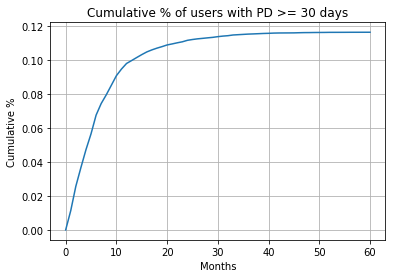

In [27]:
pd_date_cumulative.plot(grid=True,
                         title='Cumulative % of users with PD >= 30 days')
plt.xlabel('Months')
plt.ylabel('Cumulative %')

Text(0, 0.5, 'Cumulative %')

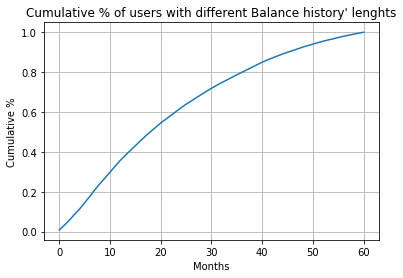

In [28]:
months_on_books_cumulative.plot(grid=True,
                         title='Cumulative % of users with different Balance history\' lenghts')
plt.xlabel('Months')
plt.ylabel('Cumulative %')

We see that 60 months is the maximum lenght of Balance history and covers all users.

The Performance Window of 20 days reveals about 95% of bad users 
and covers about 55% of all users. 

## 2.3 Target collection

In [29]:
y = grouped['PD_MONTH'].agg(np.min)\
                .apply(lambda x: 0 if (x > 0 and x <= 19) else 1)\
                .to_frame('target_value')

In [30]:
y.target_value.value_counts(normalize=True)

1    0.8924
0    0.1076
Name: target_value, dtype: float64

# 3. Preprocessing

In [31]:
df.drop_duplicates(subset='ID', keep=False, inplace=True)

In [32]:
df.drop('FLAG_MOBIL', axis=1, inplace=True)

In [33]:
df.rename(columns={'CODE_GENDER': 'gender',
                   'FLAG_OWN_CAR': 'car',
                   'FLAG_OWN_REALTY': 'realty',
                   'CNT_CHILDREN': 'children',
                   'AMT_INCOME_TOTAL': 'inc_total',
                   'NAME_INCOME_TYPE': 'inc_type',
                   'NAME_EDUCATION_TYPE': 'edu',
                   'NAME_FAMILY_STATUS': 'marital',
                   'NAME_HOUSING_TYPE': 'housing',
                   'DAYS_BIRTH': 'age',
                   'DAYS_EMPLOYED': 'years_employed',
                   'FLAG_WORK_PHONE': 'work_phone',
                   'FLAG_PHONE': 'phone',
                   'FLAG_EMAIL': 'email',
                   'OCCUPATION_TYPE': 'occpn_type',
                   'CNT_FAM_MEMBERS': 'cnt_family_members'},
          inplace=True)

In [35]:
df['age'] = - df['age']//365
df['years_employed'] = - df['years_employed']//365

In [36]:
df['occpn_type'] = df['occpn_type'].to_frame().fillna('Unknown')

## 3.1 Categorical features one-hot encoding

In [37]:
# Join numeric features with encoded categorical ones. 
xdf = df.loc[:, df.dtypes != 'object']\
        .merge(right=pd.get_dummies(df.loc[:, df.dtypes == 'object']),
               left_index=True,
               right_index=True)

In [38]:
xdf.head(5)

,ID,children,inc_total,age,years_employed,work_phone,phone,email,cnt_family_members,gender_F,gender_M,car_N,car_Y,realty_N,realty_Y,inc_type_Commercial associate,inc_type_Pensioner,inc_type_State servant,inc_type_Student,inc_type_Working,edu_Academic degree,edu_Higher education,edu_Incomplete higher,edu_Lower secondary,edu_Secondary / secondary special,marital_Civil marriage,marital_Married,marital_Separated,marital_Single / not married,marital_Widow,housing_Co-op apartment,housing_House / apartment,housing_Municipal apartment,housing_Office apartment,housing_Rented apartment,housing_With parents,occpn_type_Accountants,occpn_type_Cleaning staff,occpn_type_Cooking staff,occpn_type_Core staff,occpn_type_Drivers,occpn_type_HR staff,occpn_type_High skill tech staff,occpn_type_IT staff,occpn_type_Laborers,occpn_type_Low-skill Laborers,occpn_type_Managers,occpn_type_Medicine staff,occpn_type_Private service staff,occpn_type_Realty agents,occpn_type_Sales staff,occpn_type_Secretaries,occpn_type_Security staff,occpn_type_Unknown,occpn_type_Waiters/barmen staff
0,5008804,0,427500.0,-1,12,1,0,0,2.0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,5008805,0,427500.0,-1,12,1,0,0,2.0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5008806,0,112500.0,-1,3,0,0,0,2.0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,5008808,0,270000.0,-1,8,0,1,1,1.0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5008809,0,270000.0,-1,8,0,1,1,1.0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [39]:
xydf = xdf.merge(y, on='ID')

In [40]:
X = xydf.drop(['ID', 'target_value'], axis=1)
y = xydf['target_value']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42, stratify=y)

## 3.2 Oversampling the minority class

In [50]:
sm = SMOTE(random_state=42)

In [51]:
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [60]:
y_train.value_counts()

1    16221
0     2007
Name: target_value, dtype: int64

In [61]:
y_smote.value_counts()

1    16221
0    16221
Name: target_value, dtype: int64

In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(X_smote, y_smote, test_size=0.20, random_state=42, stratify=y_smote)

# 4. Model

## 4.1 Hyperparameters tuning

In [82]:
def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [102]:
fit_params_valid={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_valid, y_valid)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [70]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [103]:
n_HP_points_to_test = 100

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=2000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [104]:
gs.fit(X_train, y_train, **fit_params_valid)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.92006


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[200]	valid's auc: 0.930682
[300]	valid's auc: 0.936373
[400]	valid's auc: 0.93968
[500]	valid's auc: 0.942214
[600]	valid's auc: 0.944083
[700]	valid's auc: 0.945373
[800]	valid's auc: 0.946283
[900]	valid's auc: 0.947259
[1000]	valid's auc: 0.948066
[1100]	valid's auc: 0.948919
[1200]	valid's auc: 0.949581
[1300]	valid's auc: 0.950204
[1400]	valid's auc: 0.950783
[1500]	valid's auc: 0.951169
[1600]	valid's auc: 0.951573
[1700]	valid's auc: 0.951979
[1800]	valid's auc: 0.952387
[1900]	valid's auc: 0.952723
[2000]	valid's auc: 0.952982
Did not meet early stopping. Best iteration is:
[1999]	valid's auc: 0.952987
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.917277
[200]	valid's auc: 0.928548
[300]	valid's auc: 0.934381
[400]	valid's auc: 0.937532
[500]	valid's auc: 0.940067
[600]	valid's auc: 0.941819
[700]	valid's auc: 0.943165
[800]	valid's auc: 0.944098
[900]	valid's auc: 0.945178
[1000]	valid's auc: 0.946022
[1100]	valid's auc: 0.946683
[1200]	val

[1300]	valid's auc: 0.949171
[1400]	valid's auc: 0.949552
[1500]	valid's auc: 0.949821
[1600]	valid's auc: 0.950128
Early stopping, best iteration is:
[1641]	valid's auc: 0.950233
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.913054
[200]	valid's auc: 0.927222
[300]	valid's auc: 0.934042
[400]	valid's auc: 0.937376
[500]	valid's auc: 0.939484
[600]	valid's auc: 0.941165
[700]	valid's auc: 0.942832
[800]	valid's auc: 0.943718
[900]	valid's auc: 0.944368
[1000]	valid's auc: 0.944795
[1100]	valid's auc: 0.945478
[1200]	valid's auc: 0.945973
[1300]	valid's auc: 0.946333
Early stopping, best iteration is:
[1275]	valid's auc: 0.946373
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.913543
[200]	valid's auc: 0.927308
[300]	valid's auc: 0.933479
[400]	valid's auc: 0.936915
[500]	valid's auc: 0.939499
[600]	valid's auc: 0.940966
Early stopping, best iteration is:
[644]	valid's auc: 0.941927
Training until validation scores do

[1200]	valid's auc: 0.940973
[1300]	valid's auc: 0.941341
[1400]	valid's auc: 0.941647
[1500]	valid's auc: 0.941937
[1600]	valid's auc: 0.942252
[1700]	valid's auc: 0.942462
[1800]	valid's auc: 0.942746
[1900]	valid's auc: 0.942906
[2000]	valid's auc: 0.942989
Did not meet early stopping. Best iteration is:
[1994]	valid's auc: 0.943012
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.919311
[200]	valid's auc: 0.930813
[300]	valid's auc: 0.93607
[400]	valid's auc: 0.938839
[500]	valid's auc: 0.940531
[600]	valid's auc: 0.942015
[700]	valid's auc: 0.943456
[800]	valid's auc: 0.94442
[900]	valid's auc: 0.945315
[1000]	valid's auc: 0.945817
[1100]	valid's auc: 0.946484
[1200]	valid's auc: 0.946866
[1300]	valid's auc: 0.947203
[1400]	valid's auc: 0.947662
[1500]	valid's auc: 0.94807
[1600]	valid's auc: 0.94836
[1700]	valid's auc: 0.948607
[1800]	valid's auc: 0.948788
[1900]	valid's auc: 0.949112
[2000]	valid's auc: 0.949363
Did not meet early stopping. Best 

[2000]	valid's auc: 0.953248
Did not meet early stopping. Best iteration is:
[1999]	valid's auc: 0.953263
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.915093
[200]	valid's auc: 0.926921
[300]	valid's auc: 0.932531
[400]	valid's auc: 0.936529
[500]	valid's auc: 0.939183
[600]	valid's auc: 0.941391
[700]	valid's auc: 0.942969
[800]	valid's auc: 0.944082
[900]	valid's auc: 0.945177
[1000]	valid's auc: 0.94609
[1100]	valid's auc: 0.946973
[1200]	valid's auc: 0.947603
[1300]	valid's auc: 0.948347
[1400]	valid's auc: 0.948797
[1500]	valid's auc: 0.949222
[1600]	valid's auc: 0.949708
[1700]	valid's auc: 0.950125
[1800]	valid's auc: 0.950705
[1900]	valid's auc: 0.951048
[2000]	valid's auc: 0.951341
Did not meet early stopping. Best iteration is:
[1996]	valid's auc: 0.951351
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.916447
[200]	valid's auc: 0.927889
[300]	valid's auc: 0.933049
[400]	valid's auc: 0.936451
[500]	valid's

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.93233
[200]	valid's auc: 0.941501
[300]	valid's auc: 0.9454
[400]	valid's auc: 0.947546
[500]	valid's auc: 0.949012
[600]	valid's auc: 0.950092
[700]	valid's auc: 0.95112
[800]	valid's auc: 0.951725
[900]	valid's auc: 0.9524
[1000]	valid's auc: 0.952911
[1100]	valid's auc: 0.953169
[1200]	valid's auc: 0.953557
[1300]	valid's auc: 0.953769
[1400]	valid's auc: 0.9541
[1500]	valid's auc: 0.954382
[1600]	valid's auc: 0.954549
[1700]	valid's auc: 0.954796
[1800]	valid's auc: 0.954993
[1900]	valid's auc: 0.955188
[2000]	valid's auc: 0.955435
Did not meet early stopping. Best iteration is:
[2000]	valid's auc: 0.955435
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.930972
[200]	valid's auc: 0.940527
[300]	valid's auc: 0.944181
[400]	valid's auc: 0.946535
[500]	valid's auc: 0.947626
[600]	valid's auc: 0.948616
[700]	valid's auc: 0.949234
[800]	valid's auc: 0.949892
[900]	valid's 

[1000]	valid's auc: 0.95173
[1100]	valid's auc: 0.952409
[1200]	valid's auc: 0.952984
[1300]	valid's auc: 0.953437
[1400]	valid's auc: 0.953912
[1500]	valid's auc: 0.954381
[1600]	valid's auc: 0.954774
[1700]	valid's auc: 0.955217
[1800]	valid's auc: 0.955505
[1900]	valid's auc: 0.95582
Early stopping, best iteration is:
[1922]	valid's auc: 0.955877
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.926237
[200]	valid's auc: 0.936294
[300]	valid's auc: 0.941585
[400]	valid's auc: 0.945424
[500]	valid's auc: 0.947508
[600]	valid's auc: 0.9491
[700]	valid's auc: 0.950283
[800]	valid's auc: 0.951132
[900]	valid's auc: 0.951826
[1000]	valid's auc: 0.952265
[1100]	valid's auc: 0.952872
[1200]	valid's auc: 0.953479
[1300]	valid's auc: 0.95386
[1400]	valid's auc: 0.954111
[1500]	valid's auc: 0.954474
[1600]	valid's auc: 0.954703
[1700]	valid's auc: 0.955076
[1800]	valid's auc: 0.955206
Early stopping, best iteration is:
[1852]	valid's auc: 0.9554
Training until 

[200]	valid's auc: 0.91939
[300]	valid's auc: 0.92613
[400]	valid's auc: 0.929704
[500]	valid's auc: 0.932802
[600]	valid's auc: 0.934778
[700]	valid's auc: 0.936819
[800]	valid's auc: 0.938487
[900]	valid's auc: 0.939552
[1000]	valid's auc: 0.940524
[1100]	valid's auc: 0.941175
[1200]	valid's auc: 0.941974
[1300]	valid's auc: 0.942693
[1400]	valid's auc: 0.943426
[1500]	valid's auc: 0.943845
[1600]	valid's auc: 0.94432
[1700]	valid's auc: 0.944743
[1800]	valid's auc: 0.945025
[1900]	valid's auc: 0.945384
[2000]	valid's auc: 0.94574
Did not meet early stopping. Best iteration is:
[1988]	valid's auc: 0.945779
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.905421
[200]	valid's auc: 0.918625
[300]	valid's auc: 0.924932
[400]	valid's auc: 0.928754
[500]	valid's auc: 0.931637
[600]	valid's auc: 0.933401
[700]	valid's auc: 0.934817
[800]	valid's auc: 0.936214
[900]	valid's auc: 0.937173
[1000]	valid's auc: 0.938134
[1100]	valid's auc: 0.938764
[1200]	valid'

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.76469
[200]	valid's auc: 0.784657
[300]	valid's auc: 0.791426
[400]	valid's auc: 0.794876
[500]	valid's auc: 0.79652
Early stopping, best iteration is:
[539]	valid's auc: 0.796971
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.763644
[200]	valid's auc: 0.779492
[300]	valid's auc: 0.787153
[400]	valid's auc: 0.791161
[500]	valid's auc: 0.792564
Early stopping, best iteration is:
[496]	valid's auc: 0.792767
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.887551
[200]	valid's auc: 0.891869
[300]	valid's auc: 0.892929
Early stopping, best iteration is:
[302]	valid's auc: 0.892974
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.887436
[200]	valid's auc: 0.892193
Early stopping, best iteration is:
[257]	valid's auc: 0.892601
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.8859

[600]	valid's auc: 0.936169
[700]	valid's auc: 0.938113
[800]	valid's auc: 0.939729
[900]	valid's auc: 0.94105
[1000]	valid's auc: 0.942111
[1100]	valid's auc: 0.943117
[1200]	valid's auc: 0.944072
[1300]	valid's auc: 0.944694
[1400]	valid's auc: 0.945344
[1500]	valid's auc: 0.946164
[1600]	valid's auc: 0.946587
[1700]	valid's auc: 0.946975
[1800]	valid's auc: 0.947306
[1900]	valid's auc: 0.947599
[2000]	valid's auc: 0.948114
Did not meet early stopping. Best iteration is:
[2000]	valid's auc: 0.948114
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.764919
[200]	valid's auc: 0.783753
[300]	valid's auc: 0.791107
[400]	valid's auc: 0.794253
[500]	valid's auc: 0.795016
[600]	valid's auc: 0.795659
Early stopping, best iteration is:
[643]	valid's auc: 0.795839
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.766125
[200]	valid's auc: 0.78554
[300]	valid's auc: 0.792683
[400]	valid's auc: 0.795534
Early stopping, best iteratio

[200]	valid's auc: 0.924603
[300]	valid's auc: 0.927874
[400]	valid's auc: 0.929492
[500]	valid's auc: 0.931121
[600]	valid's auc: 0.931916
[700]	valid's auc: 0.932757
[800]	valid's auc: 0.933718
[900]	valid's auc: 0.934509
[1000]	valid's auc: 0.935171
[1100]	valid's auc: 0.935586
[1200]	valid's auc: 0.935904
[1300]	valid's auc: 0.936116
[1400]	valid's auc: 0.936174
Early stopping, best iteration is:
[1392]	valid's auc: 0.936175
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.916793
[200]	valid's auc: 0.923609
[300]	valid's auc: 0.926956
[400]	valid's auc: 0.929014
[500]	valid's auc: 0.930566
[600]	valid's auc: 0.931534
[700]	valid's auc: 0.932427
[800]	valid's auc: 0.932961
[900]	valid's auc: 0.933528
[1000]	valid's auc: 0.933893
[1100]	valid's auc: 0.934055
Early stopping, best iteration is:
[1152]	valid's auc: 0.934166
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.897814
[200]	valid's auc: 0.909822
[300]	valid's a

[300]	valid's auc: 0.908336
[400]	valid's auc: 0.912811
[500]	valid's auc: 0.915357
[600]	valid's auc: 0.916975
[700]	valid's auc: 0.918525
[800]	valid's auc: 0.919618
[900]	valid's auc: 0.92087
[1000]	valid's auc: 0.921733
[1100]	valid's auc: 0.922639
[1200]	valid's auc: 0.923328
[1300]	valid's auc: 0.923687
[1400]	valid's auc: 0.92426
[1500]	valid's auc: 0.924833
[1600]	valid's auc: 0.925416
[1700]	valid's auc: 0.925839
[1800]	valid's auc: 0.926318
[1900]	valid's auc: 0.926657
[2000]	valid's auc: 0.927127
Did not meet early stopping. Best iteration is:
[1998]	valid's auc: 0.92713
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.933357
[200]	valid's auc: 0.942201
[300]	valid's auc: 0.946303
[400]	valid's auc: 0.948326
[500]	valid's auc: 0.949726
[600]	valid's auc: 0.95108
[700]	valid's auc: 0.952155
[800]	valid's auc: 0.953042
[900]	valid's auc: 0.953759
[1000]	valid's auc: 0.954235
[1100]	valid's auc: 0.954762
[1200]	valid's auc: 0.95516
[1300]	valid'

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.880259
[200]	valid's auc: 0.892942
[300]	valid's auc: 0.899571
[400]	valid's auc: 0.905452
[500]	valid's auc: 0.909013
[600]	valid's auc: 0.911079
[700]	valid's auc: 0.913375
[800]	valid's auc: 0.914671
[900]	valid's auc: 0.91607
[1000]	valid's auc: 0.917073
[1100]	valid's auc: 0.91797
[1200]	valid's auc: 0.919029
[1300]	valid's auc: 0.919949
[1400]	valid's auc: 0.920412
[1500]	valid's auc: 0.921215
[1600]	valid's auc: 0.921867
[1700]	valid's auc: 0.922193
[1800]	valid's auc: 0.922897
[1900]	valid's auc: 0.923269
[2000]	valid's auc: 0.923867
Did not meet early stopping. Best iteration is:
[2000]	valid's auc: 0.923867
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.884183
[200]	valid's auc: 0.898348
[300]	valid's auc: 0.906063
[400]	valid's auc: 0.909589
[500]	valid's auc: 0.912806
[600]	valid's auc: 0.914633
[700]	valid's auc: 0.916774
[800]	valid's auc: 0.918382
[900]	va

[100]	valid's auc: 0.880356
[200]	valid's auc: 0.888089
[300]	valid's auc: 0.890932
[400]	valid's auc: 0.89248
[500]	valid's auc: 0.893236
Early stopping, best iteration is:
[532]	valid's auc: 0.893367
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.88044
[200]	valid's auc: 0.887199
[300]	valid's auc: 0.889957
[400]	valid's auc: 0.891886
[500]	valid's auc: 0.892746
Early stopping, best iteration is:
[546]	valid's auc: 0.892904
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.912779
[200]	valid's auc: 0.92268
[300]	valid's auc: 0.927438
[400]	valid's auc: 0.929852
[500]	valid's auc: 0.931265
[600]	valid's auc: 0.932308
[700]	valid's auc: 0.93312
[800]	valid's auc: 0.933887
[900]	valid's auc: 0.934425
[1000]	valid's auc: 0.934961
[1100]	valid's auc: 0.93533
[1200]	valid's auc: 0.935699
[1300]	valid's auc: 0.935996
[1400]	valid's auc: 0.936321
[1500]	valid's auc: 0.936642
Early stopping, best iteration is:
[1569]	valid's a

[1400]	valid's auc: 0.930071
[1500]	valid's auc: 0.93024
Early stopping, best iteration is:
[1481]	valid's auc: 0.930281
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.910838
[200]	valid's auc: 0.91638
[300]	valid's auc: 0.91934
[400]	valid's auc: 0.921088
[500]	valid's auc: 0.922299
[600]	valid's auc: 0.923573
[700]	valid's auc: 0.924811
[800]	valid's auc: 0.925528
[900]	valid's auc: 0.92609
[1000]	valid's auc: 0.92667
[1100]	valid's auc: 0.927015
[1200]	valid's auc: 0.927634
[1300]	valid's auc: 0.928017
Early stopping, best iteration is:
[1309]	valid's auc: 0.928083
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.892029
[200]	valid's auc: 0.896149
[300]	valid's auc: 0.898614
[400]	valid's auc: 0.899012
Early stopping, best iteration is:
[451]	valid's auc: 0.899209
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.890005
[200]	valid's auc: 0.893833
[300]	valid's auc: 0.895248
Early sto

[200]	valid's auc: 0.924251
[300]	valid's auc: 0.928306
[400]	valid's auc: 0.930847
[500]	valid's auc: 0.931714
Early stopping, best iteration is:
[478]	valid's auc: 0.931734
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.905673
[200]	valid's auc: 0.915534
[300]	valid's auc: 0.919724
[400]	valid's auc: 0.922292
[500]	valid's auc: 0.923844
[600]	valid's auc: 0.924953
[700]	valid's auc: 0.926201
[800]	valid's auc: 0.926961
[900]	valid's auc: 0.927688
[1000]	valid's auc: 0.928313
[1100]	valid's auc: 0.929121
[1200]	valid's auc: 0.929696
[1300]	valid's auc: 0.930215
[1400]	valid's auc: 0.930516
[1500]	valid's auc: 0.930867
[1600]	valid's auc: 0.931226
[1700]	valid's auc: 0.931501
[1800]	valid's auc: 0.931783
[1900]	valid's auc: 0.932063
[2000]	valid's auc: 0.932376
Did not meet early stopping. Best iteration is:
[2000]	valid's auc: 0.932376
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.903957
[200]	valid's auc: 0.914458

[1200]	valid's auc: 0.927304
[1300]	valid's auc: 0.927883
[1400]	valid's auc: 0.928437
[1500]	valid's auc: 0.928791
[1600]	valid's auc: 0.929023
Early stopping, best iteration is:
[1603]	valid's auc: 0.929023
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.894517
[200]	valid's auc: 0.906779
[300]	valid's auc: 0.91322
[400]	valid's auc: 0.916392
[500]	valid's auc: 0.918905
[600]	valid's auc: 0.920813
[700]	valid's auc: 0.922349
[800]	valid's auc: 0.923476
[900]	valid's auc: 0.9247
[1000]	valid's auc: 0.925429
[1100]	valid's auc: 0.926088
[1200]	valid's auc: 0.92674
[1300]	valid's auc: 0.927397
[1400]	valid's auc: 0.927781
Early stopping, best iteration is:
[1391]	valid's auc: 0.927826
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.895372
[200]	valid's auc: 0.906787
[300]	valid's auc: 0.913204
[400]	valid's auc: 0.916369
[500]	valid's auc: 0.918816
[600]	valid's auc: 0.920243
[700]	valid's auc: 0.921422
[800]	valid's au

[600]	valid's auc: 0.930056
[700]	valid's auc: 0.931777
[800]	valid's auc: 0.933071
[900]	valid's auc: 0.934008
[1000]	valid's auc: 0.934821
[1100]	valid's auc: 0.93551
[1200]	valid's auc: 0.936407
[1300]	valid's auc: 0.936997
[1400]	valid's auc: 0.937436
[1500]	valid's auc: 0.937877
[1600]	valid's auc: 0.938357
[1700]	valid's auc: 0.938712
[1800]	valid's auc: 0.938939
Early stopping, best iteration is:
[1859]	valid's auc: 0.939082
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.906069
[200]	valid's auc: 0.916426
[300]	valid's auc: 0.921476
[400]	valid's auc: 0.925117
[500]	valid's auc: 0.927744
[600]	valid's auc: 0.929431
[700]	valid's auc: 0.930963
[800]	valid's auc: 0.931967
[900]	valid's auc: 0.932904
[1000]	valid's auc: 0.933708
[1100]	valid's auc: 0.934523
[1200]	valid's auc: 0.93523
[1300]	valid's auc: 0.936006
[1400]	valid's auc: 0.936392
[1500]	valid's auc: 0.936948
[1600]	valid's auc: 0.937429
Early stopping, best iteration is:
[1620]	valid's

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  8.3min finished


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.947361
[200]	valid's auc: 0.954543
[300]	valid's auc: 0.957203
[400]	valid's auc: 0.958967
[500]	valid's auc: 0.959737
[600]	valid's auc: 0.960127
[700]	valid's auc: 0.960558
Early stopping, best iteration is:
[693]	valid's auc: 0.9606


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(metric='None', n_estimators=2000,
                                            n_jobs=4, random_state=314),
                   n_iter=100,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022DEB47D9B0>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022DEB478710>,
                                        'min_child_weight': [1e-05, 0.001, 0.01,
                                                             0.1, 1, 10.0,
                                                             100.0, 1000.0,
                                                             10000.0],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022DEB4781D0>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
         

In [105]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.9591904396680198 with params: {'colsample_bytree': 0.952164731370897, 'min_child_samples': 111, 'min_child_weight': 0.01, 'num_leaves': 38, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.3029313662262354} 


In [106]:
clf_lr = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

#Train model with learning rate decay
clf_lr.fit(X_train, y_train, **fit_params_valid,
              callbacks=[lgb.reset_parameter(
                  learning_rate=learning_rate_010_decay_power_0995)])

Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.94432
[200]	valid's auc: 0.950327
[300]	valid's auc: 0.952659
[400]	valid's auc: 0.953504
[500]	valid's auc: 0.953993
[600]	valid's auc: 0.954335
[700]	valid's auc: 0.954542
[800]	valid's auc: 0.954643
[900]	valid's auc: 0.954684
[1000]	valid's auc: 0.954717
[1100]	valid's auc: 0.954748
[1200]	valid's auc: 0.954762
[1300]	valid's auc: 0.954798
[1400]	valid's auc: 0.954848
Early stopping, best iteration is:
[1407]	valid's auc: 0.954853


LGBMClassifier(colsample_bytree=0.952164731370897, metric='None',
               min_child_samples=111, min_child_weight=0.01, n_estimators=2000,
               n_jobs=4, num_leaves=38, random_state=314, reg_alpha=0,
               reg_lambda=0.1, subsample=0.3029313662262354)

In [107]:
opt_params = clf_lr.get_params()

## 4.2 Fitting final model

In [112]:
fit_params_test={"early_stopping_rounds":50, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test, y_test)],
            'eval_names': ['test'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [113]:
clf_final = lgb.LGBMClassifier(**opt_params)
clf_final.fit(X_smote, y_smote, **fit_params_test)

Training until validation scores don't improve for 50 rounds
[100]	test's auc: 0.630482
[200]	test's auc: 0.650256
[300]	test's auc: 0.660584
[400]	test's auc: 0.669219
[500]	test's auc: 0.677514
[600]	test's auc: 0.681221
[700]	test's auc: 0.686709
[800]	test's auc: 0.688796
[900]	test's auc: 0.6914
[1000]	test's auc: 0.693814
Early stopping, best iteration is:
[1037]	test's auc: 0.694318


LGBMClassifier(colsample_bytree=0.952164731370897, metric='None',
               min_child_samples=111, min_child_weight=0.01, n_estimators=2000,
               n_jobs=4, num_leaves=38, random_state=314, reg_alpha=0,
               reg_lambda=0.1, subsample=0.3029313662262354)

In [168]:
with open('./model/feature_names_LGBM.tsv', 'w') as f:
    for col in X_train.columns:
        f.write('%s\n' % col)

In [175]:
clf_final.booster_.save_model('./model/LGBM_classifier.txt')

In [181]:
pd.DataFrame(opt_params, index=[0]).to_csv('./model/hyper_params.csv')

## 4.3 Metrics

In [127]:
fpr_train, tpr_train, _ = roc_curve(y_smote.values,
                                    clf_final.predict_proba(X_smote.values)[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test.values,
                                    clf_final.predict_proba(X_test.values)[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

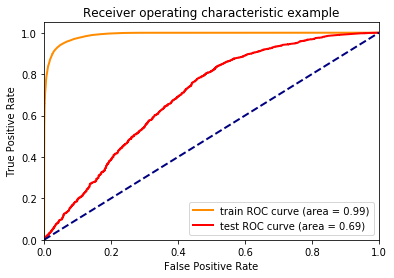

In [129]:
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red',
         lw=lw, label='test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'train Precision-Recall curve')

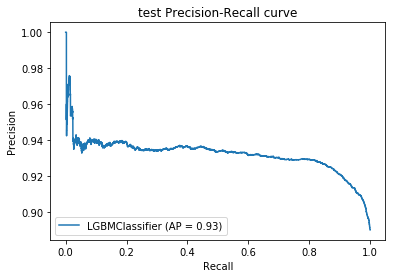

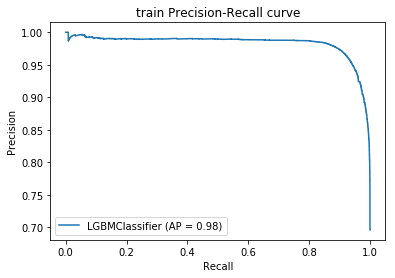

In [163]:
disp_1 = plot_precision_recall_curve(clf_final, X_test, y_test)
disp_1.ax_.set_title('test Precision-Recall curve')
disp_2 = plot_precision_recall_curve(clf_final, X_smote, y_smote)
disp_2.ax_.set_title('train Precision-Recall curve')

## 4.4 Features importances

In [134]:
shap.initjs()

In [136]:
%time

explainer = shap.TreeExplainer(clf_final)
shap_values = explainer.shap_values(X_test.values)

Wall time: 0 ns
C extension was not built during install!


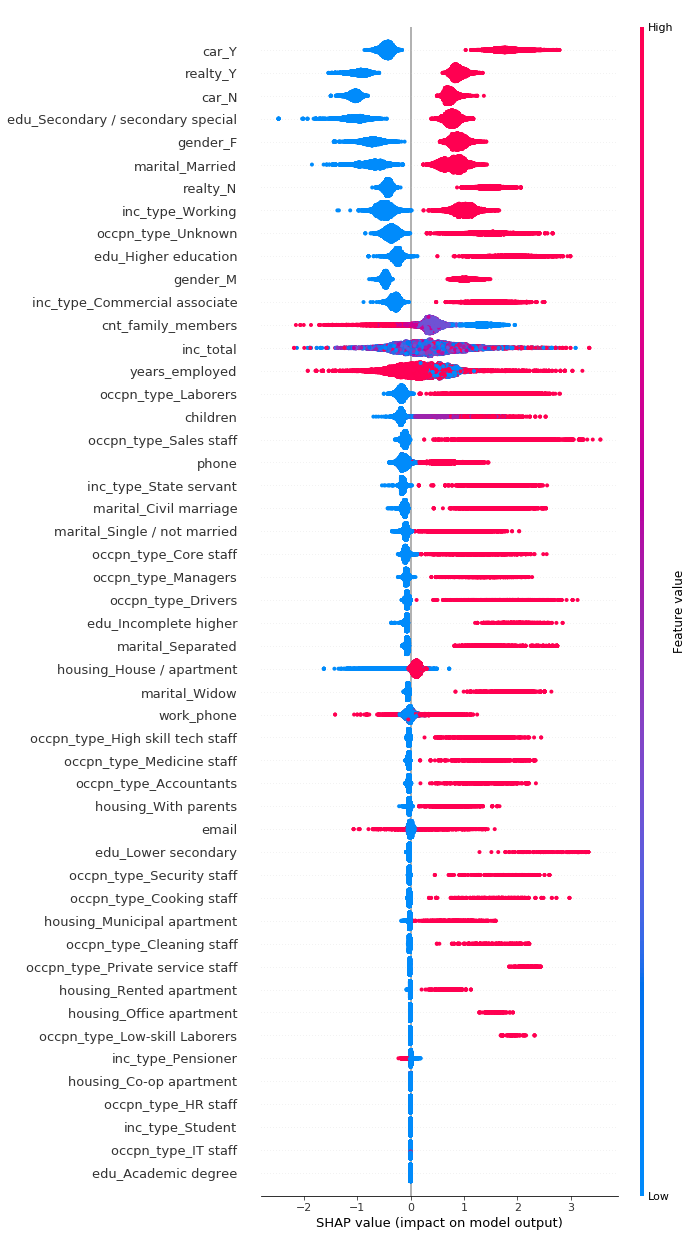

In [184]:
shap.summary_plot(shap_values[1], X_test, show=False, plot_type='dot', max_display=50)

## 4.5 Calibration Curve

In [164]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

LGBM:
	Brier: 0.110
	Precision: 0.916
	Recall: 0.927
	F1: 0.922

LGBM + Isotonic:
	Brier: 0.101
	Precision: 0.908
	Recall: 0.953
	F1: 0.930

LGBM + Sigmoid:
	Brier: 0.108
	Precision: 0.911
	Recall: 0.936
	F1: 0.924



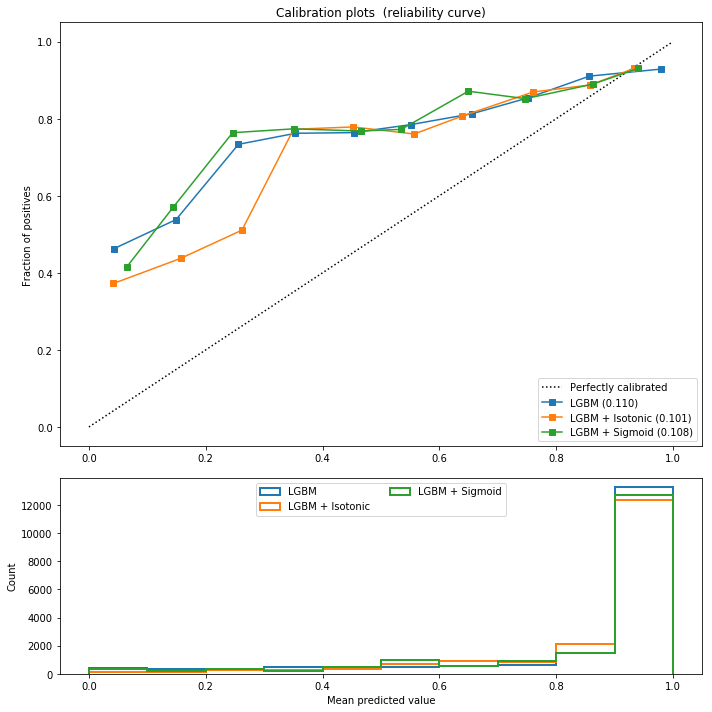

In [165]:
plot_calibration_curve(clf_final, 'LGBM', 1)